In [80]:
import cv2
import os
import random
import tensorflow as tf
import numpy as np

# Path to the directory containing the image folders
base_path = "/Users/mrbinit/Downloads/archive/"

# List to store all image file paths and corresponding labels
image_paths = []
labels = []

# Function to recursively find all image files in a directory and assign labels
def find_image_files(directory, label):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):  # Check for image file formats
                image_paths.append(os.path.join(root, file))
                labels.append(label)  # Assign label to the corresponding image

# Find image files in the 'fake-v2' folder
fake_v2_path = os.path.join(base_path, "fakeV2/fake-v2")
find_image_files(fake_v2_path, label=1)  # Assign label 1 for AI-generated images

# Find image files in the 'real' folder
real_path = os.path.join(base_path, "real")
find_image_files(real_path, label=0)  # Assign label 0 for hand-made images

# Shuffle the image paths and labels in parallel
combined_data = list(zip(image_paths, labels))
random.shuffle(combined_data)
image_paths, labels = zip(*combined_data)


### data minimize

In [77]:
# Define the percentage of data  
data_percentage = 5
num_samples = int(len(image_paths) * (data_percentage / 100))

# Use a subset of image paths and labels
sampled_image_paths = image_paths[:num_samples]
sampled_labels = labels[:num_samples]

# Load and process the sampled images
for img_path, label in zip(sampled_image_paths, sampled_labels):
    # Read the image using OpenCV
    img = cv2.imread(img_path)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


### size of the dataset

In [78]:
height, width, channels = img.shape
print(f"Image at '{img_path}' has dimensions: {width}x{height} pixels with {channels} channels")

Image at '/Users/mrbinit/Downloads/archive/real/0uqpnep6pc6a1.jpg' has dimensions: 1440x1440 pixels with 3 channels


In [79]:
prev_dataset_size = len(image_paths)
dataset_size = len(sampled_image_paths)
print('The size of the entire dataset is:', prev_dataset_size)
print('the size of the entire dataset after ', dataset_size)


The size of the entire dataset is: 21635
the size of the entire dataset after  1081


the entire dataset was huge and my computer is not capable to handle such a big dataset so I decided to use 20% of the dataset

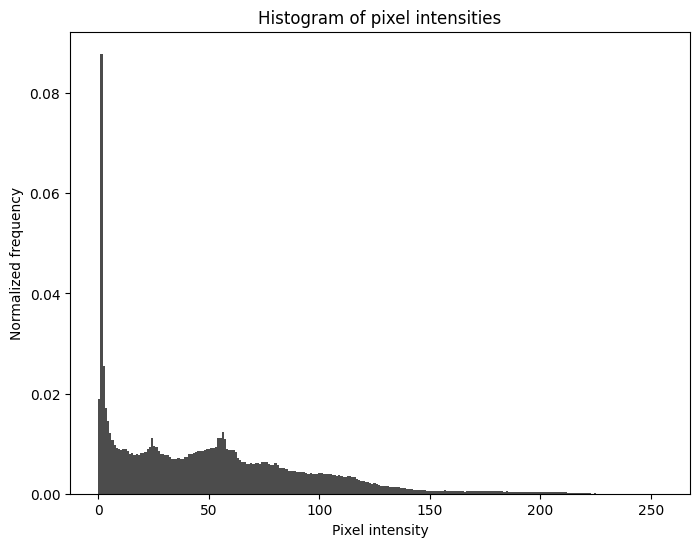

In [69]:
import matplotlib.pyplot as plt
# Plot histogram of pixel intensities for a sample image
def plot_histogram(sampled_image_paths):
    img = cv2.imread(sampled_image_paths, cv2.IMREAD_GRAYSCALE) #IMREADGREYSCALE reads the image in grey scale
    if img is not None:
        plt.figure(figsize=(8,6))
        plt.hist(img.ravel(), bins = 256, range =(0, 255), density = True, color = 'black', alpha = 0.7)
        plt.xlabel('Pixel intensity')
        plt.ylabel('Normalized frequency')
        plt.title('Histogram of pixel intensities')
        plt.show()
    else:
        print(f'Failed to read image at {sampled_image_paths}')

# Plot histogram for a sample image
sample_image_path = sampled_image_paths[0]
plot_histogram(sample_image_path)


### split the dataset

In [70]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets using sklearn
train_paths, test_val_paths, train_labels, test_val_labels = train_test_split(
    sampled_image_paths, sampled_labels, test_size=0.2, stratify=sampled_labels, random_state=42)

test_paths, val_paths, test_labels, val_labels = train_test_split(
    test_val_paths, test_val_labels, test_size=0.5, stratify=test_val_labels, random_state=42)

# Display sizes of train, test, and validation sets
print('Size of train set:', len(train_paths))
print('Size of test set:', len(test_paths))
print('Size of validation set:', len(val_paths))

Size of train set: 1730
Size of test set: 216
Size of validation set: 217


In [71]:

# Define image augmentation layers
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
]

def apply_image_augmentation(image):
    # Convert image to TensorFlow tensor
    image = tf.convert_to_tensor(image)
    # Apply each augmentation layer sequentially
    for layer in img_augmentation_layers:
        image = layer(image)
    # Convert back to NumPy array
    augmented_image = image.numpy()
    return augmented_image

def load_and_preprocess_images(image_paths, labels, input_size=224, augment=True):
    images = []
    for image_path in image_paths:
        # Read and resize image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (input_size, input_size))
        # Normalize pixel values to [0, 1]
        image = image.astype(np.float32) / 255.0

        if augment:
            augmented_image = apply_image_augmentation(image)
            images.append(augmented_image)
        else:
            images.append(image)

    images = np.array(images)
    return images, labels

In [73]:
from efficientnet.tfkeras import EfficientNetB4

# Define input size for EfficientNetB0
input_size = 224  # EfficientNetB0 input size

# Preprocess the training data
train_data = load_and_preprocess_images(train_paths, train_labels, input_size, augment=True)
val_data = load_and_preprocess_images(val_paths, val_labels, input_size, augment=False)
test_data = load_and_preprocess_images(test_paths, test_labels, input_size, augment= False)

# # Shuffle training data
# train_data = shuffle(train_data)

# Convert preprocessed data to numpy arrays
X_train, y_train = np.array([item[0] for item in train_data]), np.array([item[1] for item in train_data])
X_val, y_val = np.array([item[0] for item in val_data]), np.array([item[1] for item in val_data])
X_test, y_test = np.array([item[0] for item in test_data]), np.array([item[1] for item in test_data])

/var/folders/_7/q65t_5bs3653ct73dh3s10w00000gn/T/ipykernel_41427/2362135105.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train, y_train = np.array([item[0] for item in train_data]), np.array([item[1] for item in train_data])
/var/folders/_7/q65t_5bs3653ct73dh3s10w00000gn/T/ipykernel_41427/2362135105.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val, y_val = np.array([item[0] for item in val_data]), np.array([item[1] for item in val_data])
/var/folders/_7/q65t_5bs3653ct73dh3s10w00000gn/T/ipykernel_41427/2362135105.py:17: VisibleDepr

In [75]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Build EfficientNetB4 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))
base_model.trainable = False
# Add classification head
# dropout_rate = 0.2
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [82]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to load images and labels from a folder
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Assuming images are saved in JPG format
            img_path = os.path.join(folder_path, filename)
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(filename.split('_')[0])  # Assuming filename format: label_number.jpg

    # Convert labels to categorical format using LabelEncoder
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels)

    return np.array(images), labels

# Load images and labels from the processed folder
folder_path = '/Users/mrbinit/Downloads/preprocessed'
images, labels = load_images_from_folder(folder_path)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Assuming 2 classes (fake and real)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

# Evaluate the model (optional)
# test_images, test_labels = load_images_from_folder(test_folder_path)
# model.evaluate(test_images, test_labels)


/Users/mrbinit/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 2)

In [84]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to load images and labels from a folder
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Assuming images are saved in JPG format
            img_path = os.path.join(folder_path, filename)
            image = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(filename.split('_')[0])  # Assuming filename format: label_number.jpg

    # Convert labels to categorical format using LabelEncoder
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels)

    return np.array(images), labels

# Load images and labels from the processed folder
folder_path = '/Users/mrbinit/Downloads/preprocessed'
images, labels = load_images_from_folder(folder_path)

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Assuming 2 classes (fake and real)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels))

# Evaluate the model (optional)
# test_images, test_labels = load_images_from_folder(test_folder_path)
# model.evaluate(test_images, test_labels)


/Users/mrbinit/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 2)